# Import Packages

In [22]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn import datasets
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import jax
import jax.numpy as jnp
from jax import jit, random
from jax.scipy.stats import norm, laplace
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from functools import partial

from src.load_data import load_traintest_sparseclass
from src import conformal_Bayes_functions as cb
from src import Bayes_MCMC_functions as bmcmc


# Load Diabetes Dataset (Regression) and Generate Samples

We first demonstrate our method under a sparse linear regression model on the diabetes dataset (Efron
et al., 2004) considered by Lei (2019). The dataset is available in sklearn, and consists of n= 442
subjects, where the response variable is a continuous diabetes progression and the d= 10 covariates
consist of patient readings such as blood serum measurements. We standardize all covariates and the
response to have mean 0 and standard deviation 1.




In [23]:
# Load and prepare data
def prepare_data(test_size=0.3):
    diabetes = load_diabetes()
    X = diabetes.data
    y = diabetes.target
    
    # Standardize as mentioned in the paper
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    # Split with 30% test as in the paper
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=test_size, random_state=42
    )
    
    # Further split training into train and calibration
    X_train_split, X_cal, y_train_split, y_cal = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42
    )
    
    return X_train_split, X_cal, X_test, y_train_split, y_cal, y_test, X_train, y_train

# Load and prepare data
X_train_split, X_cal, X_test, y_train_split, y_cal, y_test, X_train, y_train = prepare_data()


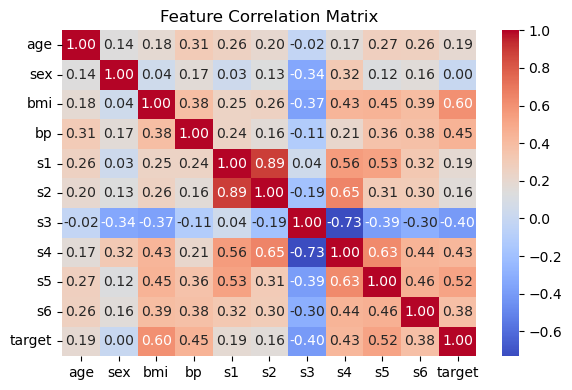

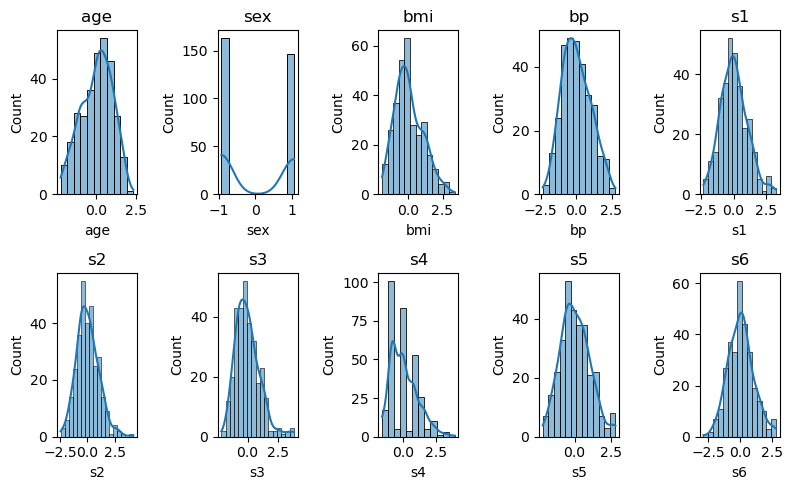

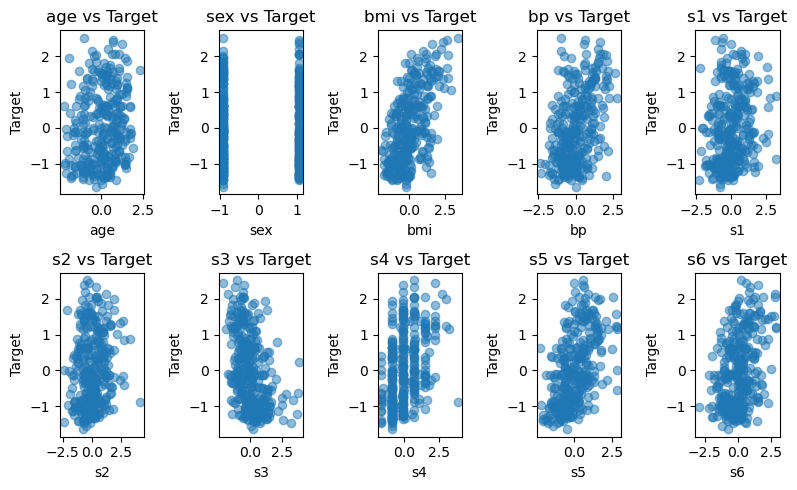

In [24]:
feature_names = load_diabetes().feature_names
df = pd.DataFrame(X_train, columns=feature_names)
df['target'] = y_train

# Plot correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Plot feature distributions
plt.figure(figsize=(8, 5))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 5, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

# Scatter plot of each feature vs target
plt.figure(figsize=(8, 5))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 5, i+1)
    plt.scatter(df[feature], df['target'], alpha=0.5)
    plt.title(f'{feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
plt.tight_layout()
plt.show()

# MCMC Bayesian posterior predictive
We compute the central $(1−\alpha)$ credible interval from the Bayesian posterior predictive CDF estimated using Monte Carlo.

## Define Bayesian sparse linear model
Instead of manually sampling the coefficients from a Normal distribution, we will set up a Bayesian hierarchical model with a Laplace (a.k.a. double-exponential) prior on the coefficients ($\theta_j$), a Gamma prior on the shrinkage parameter $( b )$, and a half‐normal prior on $( \tau )$. We will use [NumPyro](https://num.pyro.ai/) (a high-level Bayesian modeling library built on JAX) to handle MCMC sampling.

**Key Idea Bayesian Model for Sparse Linear Regression**


- **Likelihood (data distribution):**
  $$f_\theta(y | x) = \mathcal{N}(y | \theta^{\top}x + \theta_0, \tau^2)$$

- **Prior on coefficients:**
  $$\pi(\theta_j) = \text{Laplace}(0, b)$$

- **Prior on intercept:**
  $$\pi(\theta_0) \propto 1$$

- **Hyperprior on Laplace scale:**
  $$\pi(b) = \text{Gamma}(1, 1)$$

- **Prior on noise scale:**
  $$\pi(\tau) = \mathcal{N}^+(0, c)$$

- **Two settings for hyperparameter:**
  - Well-specified prior: $c = 1$
  - Poorly-specified prior: $c = 0.02$

In [25]:
def sparse_linear_model(X, y=None, c=1.0):  # c is the prior
    """
    Bayesian sparse linear model matching the paper:
      y ~ Normal(X * theta + theta_0, tau^2)
      theta_j ~ Laplace(loc=0, scale=b)
      b ~ Gamma(1, 1)
      tau ~ HalfNormal(0, c)  # c controls how informative the prior is
    """
    n_features = X.shape[1]
    
    # Prior on tau (noise scale) - now parameterized with c
    tau = numpyro.sample("tau", dist.HalfNormal(c))
    
    # Prior on b (scale parameter for Laplace)
    b = numpyro.sample("b", dist.Gamma(1.0, 1.0))
    
    # Laplace prior on each coefficient
    with numpyro.plate("coeff_plate", n_features):
        theta = numpyro.sample("theta", dist.Laplace(0.0, b))
    
    # Intercept with flat prior
    theta_0 = numpyro.sample("theta_0", dist.Normal(0., 10.))
    
    # Mean of the likelihood
    mu = jnp.dot(X, theta) + theta_0
    
    # Likelihood of y
    numpyro.sample("obs", dist.Normal(mu, tau), obs=y)

## Running MCMC for the sparse linear regression model

In [26]:
def run_mcmc_sparse_model(X, y, c=1.0, num_warmup=1000, num_samples=8000, num_chains=1):
    """
    Runs NUTS MCMC for the sparse linear regression model with specified prior parameter c.
    """
    # Create a NUTS sampler for our model with the c parameter
    kernel = NUTS(lambda X, y: sparse_linear_model(X, y, c))
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    
    # Run MCMC
    mcmc.run(jax.random.PRNGKey(0), X, y)
    mcmc.print_summary()
    
    return mcmc.get_samples()

# Run MCMC on the training data
# For well-specified prior (c=1.0)
samples_c1 = run_mcmc_sparse_model(X_train, y_train, c=1.0, num_warmup=1000, num_samples=8000)
# For poorly-specified prior (c=0.02)
samples_c002 = run_mcmc_sparse_model(X_train, y_train, c=0.02, num_warmup=1000, num_samples=8000)

print(samples_c1.keys())  # dict_keys(['sigma', 'tau', 'theta', 'intercept'])


sample: 100%|██████████| 9000/9000 [00:02<00:00, 3422.00it/s, 15 steps of size 1.94e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.19      0.07      0.17      0.08      0.29   4469.70      1.00
       tau      0.72      0.03      0.72      0.67      0.76   7895.44      1.00
  theta[0]      0.02      0.04      0.02     -0.05      0.09   6759.03      1.00
  theta[1]     -0.14      0.05     -0.14     -0.22     -0.07   6996.61      1.00
  theta[2]      0.34      0.05      0.34      0.26      0.42   6901.21      1.00
  theta[3]      0.22      0.05      0.22      0.15      0.31   6581.15      1.00
  theta[4]     -0.15      0.14     -0.13     -0.38      0.07   2281.83      1.00
  theta[5]      0.01      0.12     -0.00     -0.18      0.20   2501.37      1.00
  theta[6]     -0.10      0.09     -0.10     -0.26      0.04   3220.14      1.00
  theta[7]      0.10      0.10      0.10     -0.04      0.27   4713.90      1.00
  theta[8]      0.25      0.08      0.24      0.12      0.38   3077.22      1.00
  theta[9]      0.03      0

sample: 100%|██████████| 9000/9000 [00:02<00:00, 3068.45it/s, 31 steps of size 1.33e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.20      0.08      0.18      0.09      0.31   5342.10      1.00
       tau      0.44      0.01      0.44      0.43      0.46  12796.48      1.00
  theta[0]      0.02      0.03      0.02     -0.03      0.06  12412.09      1.00
  theta[1]     -0.15      0.03     -0.15     -0.20     -0.11  10629.45      1.00
  theta[2]      0.34      0.03      0.34      0.29      0.39  10339.59      1.00
  theta[3]      0.23      0.03      0.23      0.19      0.28   9794.65      1.00
  theta[4]     -0.27      0.14     -0.25     -0.52     -0.04   2697.82      1.00
  theta[5]      0.09      0.12      0.08     -0.09      0.29   2967.51      1.00
  theta[6]     -0.05      0.08     -0.05     -0.19      0.06   3250.78      1.00
  theta[7]      0.13      0.07      0.13      0.01      0.23   6328.74      1.00
  theta[8]      0.30      0.07      0.29      0.19      0.41   3295.84      1.00
  theta[9]      0.03      0

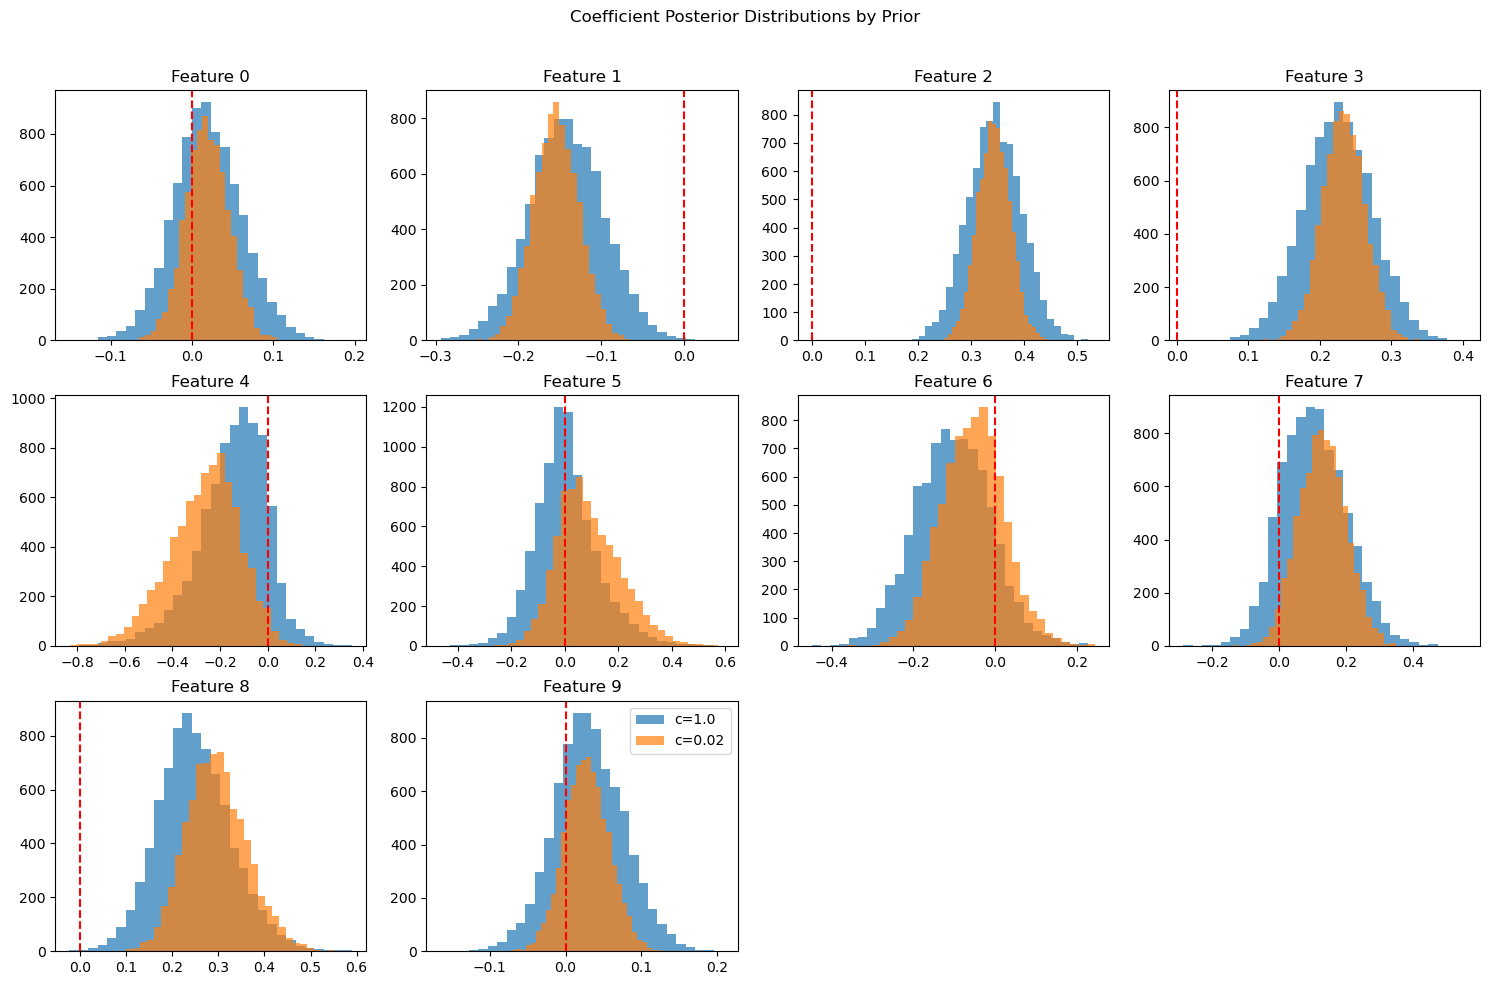

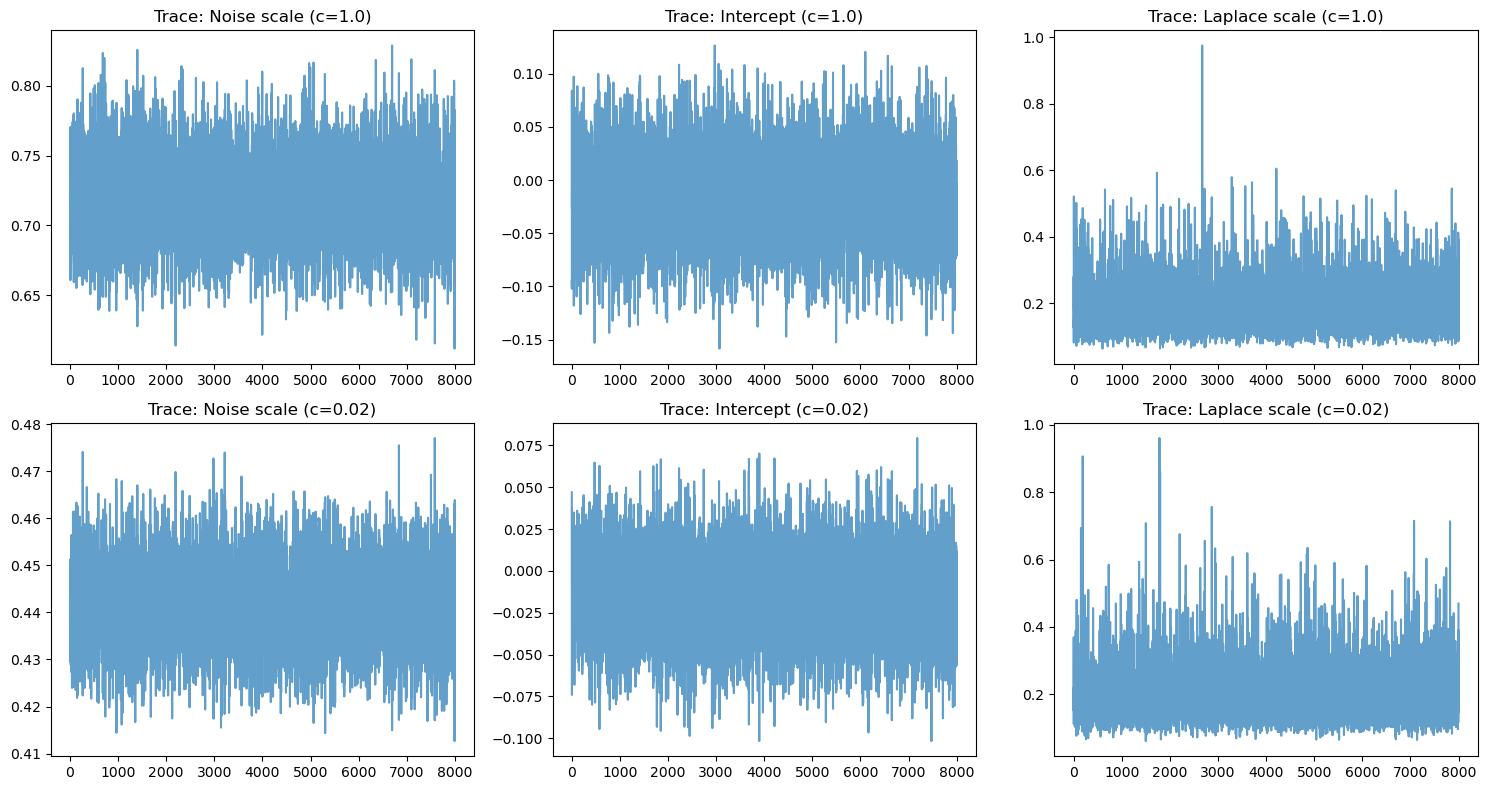

In [27]:
# 1. Compare coefficient distributions
plt.figure(figsize=(15, 10))
for i in range(X_train.shape[1]):
    plt.subplot(3, 4, i+1)
    plt.hist(samples_c1['theta'][:, i], bins=30, alpha=0.7, label='c=1.0')
    plt.hist(samples_c002['theta'][:, i], bins=30, alpha=0.7, label='c=0.02')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(f"Feature {i}")
plt.subplot(3, 4, 10)
plt.legend()
plt.tight_layout()
plt.suptitle("Coefficient Posterior Distributions by Prior")
plt.subplots_adjust(top=0.9)
plt.show()

# 2. Compare trace plots for key parameters
plt.figure(figsize=(15, 8))
params = ['tau', 'theta_0', 'b']
titles = ['Noise scale', 'Intercept', 'Laplace scale']
for i, param in enumerate(params):
    plt.subplot(2, 3, i+1)
    plt.plot(samples_c1[param], alpha=0.7, label='c=1.0')
    plt.title(f'Trace: {titles[i]} (c=1.0)')
    
    plt.subplot(2, 3, i+4)
    plt.plot(samples_c002[param], alpha=0.7, label='c=0.02')
    plt.title(f'Trace: {titles[i]} (c=0.02)')
plt.tight_layout()
plt.show()

## Posterior Prediction & Credible Intervals

Once we have posterior samples of theta, intercept, sigma, etc., we can construct predictive distributions for test points. 

misspecification value alpha = 0.2
Time taken for c=1.0: 0.40 seconds
Time taken for c=0.02: 0.40 seconds
Results (target: 80.0% coverage):
c=1.0:  Coverage: 80.45%, Avg Width: 1.8735
c=0.02: Coverage: 59.40%, Avg Width: 1.1539


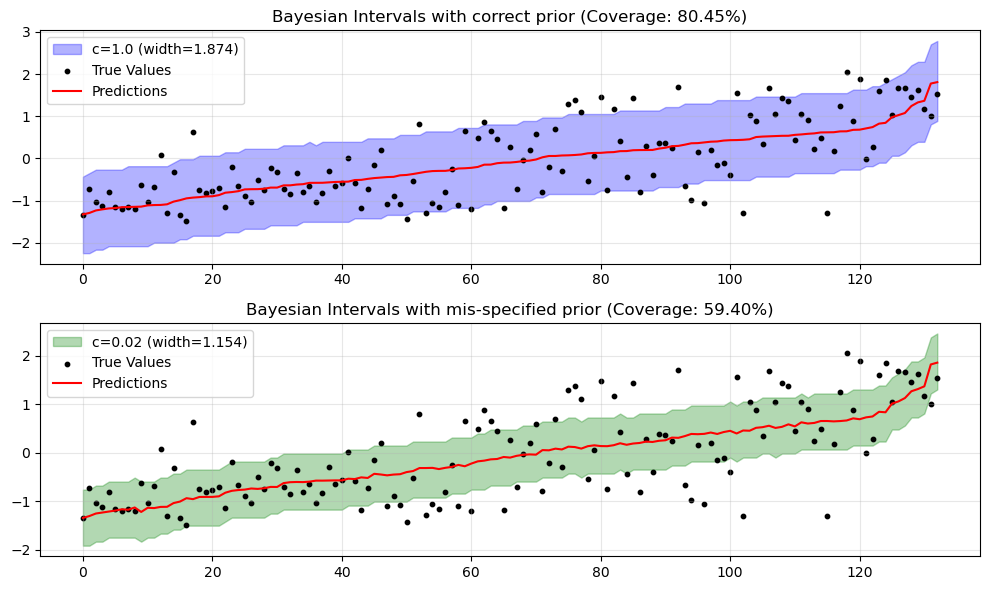

In [28]:
from src.Bayes_MCMC_functions import compute_bayes_band_MCMC # Compute Bayes band


def compute_intervals_for_all_test_points(samples, X_test, y_train, alpha=0.2):
    # Extract posterior samples
    theta_samples = samples['theta']      # shape (num_samples, d)
    intercept_samples = samples['theta_0' if 'theta_0' in samples else 'intercept']
    tau_samples = samples['tau'] if 'tau' in samples else samples['sigma']
    
    # Define y-value grid for CDF evaluation
    y_min = float(y_train.min()) - 2
    y_max = float(y_train.max()) + 2
    grid_size = 100
    y_grid = jnp.linspace(y_min, y_max, grid_size)
    
    # Initialize array to store intervals
    n_test = len(X_test)
    intervals = np.zeros((n_test, 2))
    
    # Compute intervals for each test point
    for i in range(n_test):
        x_test_jax = jnp.array(X_test[i])
        
        # Compute posterior mean for each sample
        mu_samples = (theta_samples @ x_test_jax) + intercept_samples
        
        # Compute predictive CDF (vectorized across all samples and grid points)
        cdf_pred = norm.cdf((y_grid[None, :] - mu_samples[:, None]) / tau_samples[:, None])
        
        # Compute credible interval
        band_bayes = compute_bayes_band_MCMC(alpha, y_grid, cdf_pred)
        intervals[i] = np.array(band_bayes)
    
    return intervals, y_grid

def compare_bayes_models(samples_c1, samples_c002, X_test, y_test, y_train, alpha=0.2):
    # Compute intervals for both models
    start_time = time.time()
    intervals_c1, y_grid = compute_intervals_for_all_test_points(samples_c1, X_test, y_train, alpha)
    end_time = time.time()
    Bayes_c1_time = end_time - start_time
    print(f"Time taken for c=1.0: {Bayes_c1_time:.2f} seconds")

    start_time = time.time()
    intervals_c002, _ = compute_intervals_for_all_test_points(samples_c002, X_test, y_train, alpha)
    end_time = time.time()
    Bayes_c002_time = end_time - start_time
    print(f"Time taken for c=0.02: {Bayes_c002_time:.2f} seconds")
    
    # Compute point predictions (posterior means)
    pred_c1 = np.zeros(len(X_test))
    pred_c002 = np.zeros(len(X_test))
    
    theta_c1 = samples_c1['theta']
    intercept_c1 = samples_c1['theta_0' if 'theta_0' in samples_c1 else 'intercept']
    theta_c002 = samples_c002['theta']
    intercept_c002 = samples_c002['theta_0' if 'theta_0' in samples_c002 else 'intercept']
    
    # Compute mean predictions
    for i, x in enumerate(X_test):
        pred_c1[i] = np.mean(np.dot(theta_c1, x) + intercept_c1)
        pred_c002[i] = np.mean(np.dot(theta_c002, x) + intercept_c002)
    
    # Compute coverage
    coverage_c1 = np.mean((y_test >= intervals_c1[:, 0]) & (y_test <= intervals_c1[:, 1]))
    coverage_c002 = np.mean((y_test >= intervals_c002[:, 0]) & (y_test <= intervals_c002[:, 1]))
    
    # Compute average width
    width_c1 = np.mean(intervals_c1[:, 1] - intervals_c1[:, 0])
    width_c002 = np.mean(intervals_c002[:, 1] - intervals_c002[:, 0])
    
    print(f"Results (target: {1-alpha:.1%} coverage):")
    print(f"c=1.0:  Coverage: {coverage_c1:.2%}, Avg Width: {width_c1:.4f}")
    print(f"c=0.02: Coverage: {coverage_c002:.2%}, Avg Width: {width_c002:.4f}")
    
    # Visualize the results
    plt.figure(figsize=(10, 6))
    
    # Sort test points by predicted value for better visualization
    sort_idx = np.argsort(pred_c1)
    y_test_sorted = y_test[sort_idx]
    
    # Plot intervals for c=1.0
    plt.subplot(2, 1, 1)
    plt.fill_between(range(len(y_test)), 
                     intervals_c1[sort_idx, 0], 
                     intervals_c1[sort_idx, 1], 
                     alpha=0.3, color='blue', 
                     label=f'c=1.0 (width={width_c1:.3f})')
    plt.scatter(range(len(y_test)), y_test_sorted, color='black', s=10, label='True Values')
    plt.plot(range(len(y_test)), pred_c1[sort_idx], 'r-', label='Predictions')
    plt.title(f'Bayesian Intervals with correct prior (Coverage: {coverage_c1:.2%})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot intervals for c=0.02
    plt.subplot(2, 1, 2)
    plt.fill_between(range(len(y_test)), 
                     intervals_c002[sort_idx, 0], 
                     intervals_c002[sort_idx, 1], 
                     alpha=0.3, color='green', 
                     label=f'c=0.02 (width={width_c002:.3f})')
    plt.scatter(range(len(y_test)), y_test_sorted, color='black', s=10, label='True Values')
    plt.plot(range(len(y_test)), pred_c002[sort_idx], 'r-', label='Predictions')
    plt.title(f'Bayesian Intervals with mis-specified prior (Coverage: {coverage_c002:.2%})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return intervals_c1, intervals_c002, coverage_c1, coverage_c002, Bayes_c1_time, Bayes_c002_time, pred_c1, pred_c002

# Usage (samples have already been obtained from MCMC):
alpha = 0.2
print(f"misspecification value alpha = {alpha}")
intervals_c1, intervals_c002, coverage_c1, coverage_c002, Bayes_c1_time, Bayes_c002_time, pred_c1, pred_c002 = compare_bayes_models(
    samples_c1, samples_c002, X_test, y_test, y_train, alpha=alpha
)

# Split CP and Full CP baseline

In [29]:
from src.conformal_predicion import split_conformal_prediction, full_conformal_prediction, grid_conformal_prediction, predict_with_split_cp

# Compare all methods with alpha=0.2 as in the paper
X_train_split, X_cal, X_test, y_train_split, y_cal, y_test, X_train_full, y_train_full = prepare_data(test_size=0.3)
alpha = 0.2  # As used in the paper

# 1. Split Conformal Prediction
start_time = time.time()
split_model, split_q, split_alpha = split_conformal_prediction(X_train_split, y_train_split, X_cal, y_cal, alpha)
split_time = time.time() - start_time
split_lower, split_upper, split_pred = predict_with_split_cp(split_model, split_q, X_test)
print(f"Split conformal completed in {split_time:.2f}s - Lasso alpha: {split_alpha:.6f}")

# 2. Full Conformal Prediction
start_time = time.time()
full_lower, full_upper, full_pred, full_alpha = full_conformal_prediction(X_train_full, y_train_full, X_test, alpha)
full_time = time.time() - start_time
print(f"Full conformal completed in {full_time:.2f}s - Lasso alpha: {full_alpha:.6f}")

# 5. Grid Conformal Prediction (for a subset of test points)
# Choose a small subset of test points for grid method due to computational cost
n_grid_points = 10
grid_indices = np.random.choice(len(X_test), n_grid_points, replace=False)

grid_lower = np.zeros(n_grid_points)
grid_upper = np.zeros(n_grid_points)
grid_pred = np.zeros(n_grid_points)

start_time = time.time()
for i, idx in enumerate(grid_indices):
    print(f"Processing grid point {i+1}/{n_grid_points}...")
    gl, gu, gp = grid_conformal_prediction(X_train_full, y_train_full, X_test[idx], alpha, best_alpha=0.004)
    grid_lower[i] = gl
    grid_upper[i] = gu
    grid_pred[i] = gp
grid_time = time.time() - start_time

# Calculate coverage and interval widths
split_coverage = np.mean((y_test >= split_lower) & (y_test <= split_upper))
full_coverage = np.mean((y_test >= full_lower) & (y_test <= full_upper))

split_width = np.mean(split_upper - split_lower)
full_width = np.mean(full_upper - full_lower)

# Calculate grid method coverage and width on the subset
grid_coverage = np.mean((y_test[grid_indices] >= grid_lower) & (y_test[grid_indices] <= grid_upper))
grid_width = np.mean(grid_upper - grid_lower)

# Calculate Bayes method coverage and width
width_c1 = np.mean(intervals_c1[:, 1] - intervals_c1[:, 0])
width_c002 = np.mean(intervals_c002[:, 1] - intervals_c002[:, 0])

print(f"\nResults Summary (target coverage: {1-alpha:.1%}):")
print(f"Split Conformal      - Coverage: {split_coverage:.2%}, Width: {split_width:.4f}, Time: {split_time:.2f}s")
print(f"Full Conformal       - Coverage: {full_coverage:.2%}, Width: {full_width:.4f}, Time: {full_time:.2f}s")
print(f"Grid Conformal       - Coverage: {grid_coverage:.2%}, Width: {grid_width:.4f}, Time: {grid_time:.2f}s (for {n_grid_points} points)")
print(f"Bayes (c=1.0)        - Coverage: {coverage_c1:.2%}, Width: {width_c1:.4f}, Time: {Bayes_c1_time:.2f}s")
print(f"Bayes (c=0.02)       - Coverage: {coverage_c002:.2%}, Width: {width_c002:.4f}, Time: {Bayes_c002_time:.2f}s")

Split conformal completed in 0.02s - Lasso alpha: 0.044240
Full conformal completed in 0.00s - Lasso alpha: 0.004000
Processing grid point 1/10...
Processing grid point 2/10...
Processing grid point 3/10...
Processing grid point 4/10...
Processing grid point 5/10...
Processing grid point 6/10...
Processing grid point 7/10...
Processing grid point 8/10...
Processing grid point 9/10...
Processing grid point 10/10...

Results Summary (target coverage: 80.0%):
Split Conformal      - Coverage: 84.96%, Width: 2.0703, Time: 0.02s
Full Conformal       - Coverage: 78.20%, Width: 1.7744, Time: 0.00s
Grid Conformal       - Coverage: 100.00%, Width: 8.1685, Time: 0.59s (for 10 points)
Bayes (c=1.0)        - Coverage: 80.45%, Width: 1.8735, Time: 0.40s
Bayes (c=0.02)       - Coverage: 59.40%, Width: 1.1539, Time: 0.40s


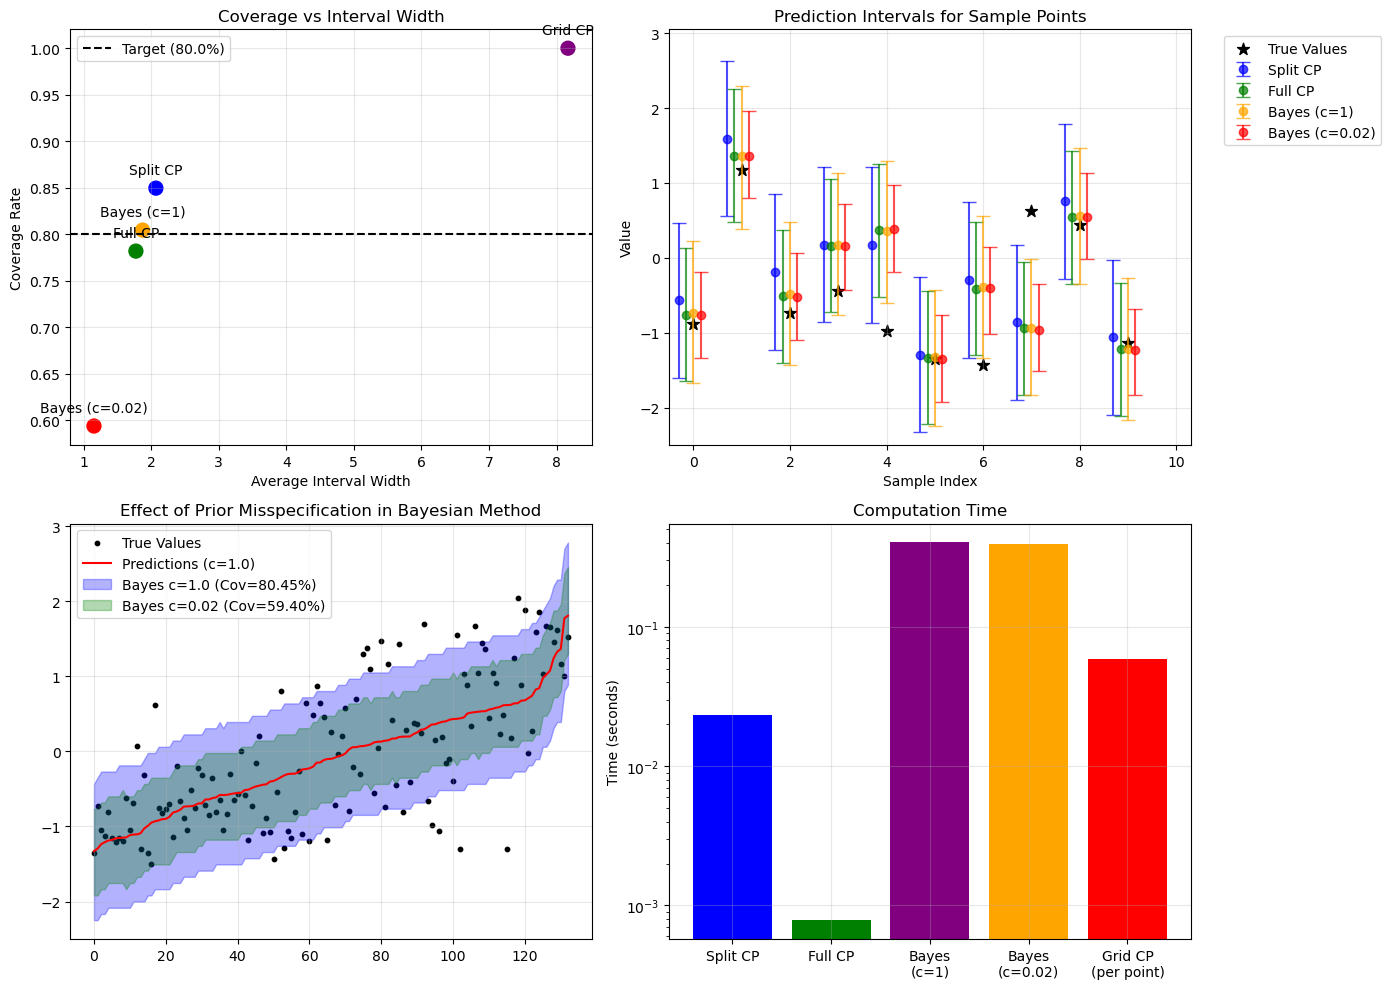

In [30]:
# VISUALIZATION SECTION
# Create a summary plot that matches the paper's style
plt.figure(figsize=(14, 10))

# Plot coverage vs. width
plt.subplot(2, 2, 1)
methods = ['Split CP', 'Full CP', 'Grid CP', 'Bayes (c=1)', 'Bayes (c=0.02)']
colors = ['blue', 'green', 'purple', 'orange', 'red']
coverage_values = [split_coverage, full_coverage, grid_coverage, coverage_c1, coverage_c002]
width_values = [split_width, full_width, grid_width, width_c1, width_c002]

plt.scatter(width_values, coverage_values, c=colors, s=100)
for i, method in enumerate(methods):
    plt.annotate(method, (width_values[i], coverage_values[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.axhline(y=1-alpha, color='black', linestyle='--', label=f'Target ({1-alpha:.1%})')
plt.xlabel('Average Interval Width')
plt.ylabel('Coverage Rate')
plt.title('Coverage vs Interval Width')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot intervals for a few sample points
sample_size = min(10, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
sample_indices = np.sort(sample_indices)

plt.subplot(2, 2, 2)
x_pos = np.arange(sample_size)
bar_width = 0.15

# Plot true values
plt.scatter(x_pos, y_test[sample_indices], s=80, marker='*', color='black', label='True Values')

# Plot intervals for each method
plt.errorbar(x_pos - 2*bar_width, split_pred[sample_indices], 
             yerr=[(split_pred[sample_indices] - split_lower[sample_indices]), 
                   (split_upper[sample_indices] - split_pred[sample_indices])],
             fmt='o', capsize=5, color='blue', label='Split CP', alpha=0.7)

plt.errorbar(x_pos - bar_width, full_pred[sample_indices], 
             yerr=[(full_pred[sample_indices] - full_lower[sample_indices]), 
                   (full_upper[sample_indices] - full_pred[sample_indices])],
             fmt='o', capsize=5, color='green', label='Full CP', alpha=0.7)

plt.errorbar(x_pos, pred_c1[sample_indices], 
                  yerr=[(pred_c1[sample_indices] - intervals_c1[sample_indices, 0]), 
                        (intervals_c1[sample_indices, 1] - pred_c1[sample_indices])],
                  fmt='o', capsize=5, color='orange', label='Bayes (c=1)', alpha=0.7)

plt.errorbar(x_pos + bar_width, pred_c002[sample_indices],
                  yerr=[(pred_c002[sample_indices] - intervals_c002[sample_indices, 0]), 
                        (intervals_c002[sample_indices, 1] - pred_c002[sample_indices])],
                  fmt='o', capsize=5, color='red', label='Bayes (c=0.02)', alpha=0.7)

# grid_plot_indices = np.arange(len(grid_indices))
# plt.errorbar(grid_plot_indices, grid_pred, 
#              yerr=[(grid_pred - grid_lower), 
#                    (grid_upper - grid_pred)],
#              fmt='o', capsize=5, color='purple', label='Grid CP', alpha=0.7)

plt.xlim(-0.5, sample_size + 2*bar_width)
plt.ylim(y_test.min() - 1, y_test.max() + 1)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Prediction Intervals for Sample Points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Plot showing effect of poor prior on Bayesian method
plt.subplot(2, 2, 3)
# Sort by prediction values for better visualization
sort_idx = np.argsort(pred_c1)
y_test_sorted = y_test[sort_idx]

plt.scatter(range(len(y_test)), y_test_sorted, color='black', s=10, label='True Values')
plt.plot(range(len(y_test)), pred_c1[sort_idx], 'r-', label='Predictions (c=1.0)')

# Plot both Bayesian intervals for comparison
plt.fill_between(range(len(y_test)), 
                 intervals_c1[sort_idx, 0], 
                 intervals_c1[sort_idx, 1], 
                 alpha=0.3, color='blue', 
                 label=f'Bayes c=1.0 (Cov={coverage_c1:.2%})')

plt.fill_between(range(len(y_test)),
                 intervals_c002[sort_idx, 0], 
                 intervals_c002[sort_idx, 1], 
                 alpha=0.3, color='green', 
                 label=f'Bayes c=0.02 (Cov={coverage_c002:.2%})')

plt.title('Effect of Prior Misspecification in Bayesian Method')
plt.legend()
plt.grid(True, alpha=0.3)

# Time comparison
plt.subplot(2, 2, 4)
method_labels = ['Split CP', 'Full CP', 'Bayes\n(c=1)', 'Bayes\n(c=0.02)', 'Grid CP\n(per point)']
times = [split_time, full_time, Bayes_c1_time, Bayes_c002_time, grid_time/n_grid_points]

plt.bar(method_labels, times, color=colors)
plt.title('Computation Time')
plt.ylabel('Time (seconds)')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Bayesian CP

def compute_logp_ygrid(X_test_row, y_grid, beta_samples, intercept_samples, sigma_samples):
def compute_logp_ygrid(X_test_row, y_grid, beta_samples, intercept_samples, sigma_samples):
## AOI Predictive Density Computation `compute_logp_ygrid`
- **Purpose:** For a single test point $X_\text{test row}$ and a grid of possible $y$ values ($y_\text{grid}$), it computes the log-density $\log p(y | X, \theta)$ for every posterior sample.

- **Vectorization:**
  - It computes the predictive mean for each posterior draw as $\text{mean}_i = \beta_i \cdot X_\text{test row} + \text{intercept}_i$.
  
  - The nested function $\text{single\_y\_logpdf}$ computes the log-density of a normal distribution using the formula:
    
    $\log p(y | \theta_i) = -\frac{1}{2} \log(2\pi) - \log(\sigma_i) - \frac{1}{2} \left(\frac{y - \mu_i}{\sigma_i}\right)^2$

  - $\text{jax.vmap}$ is used to efficiently vectorize the computation over all grid points.

- **Output:**
  - The function returns an array of shape $(B, \text{grid\_size})$, where $B$ is the number of posterior samples.

In [31]:
from scipy.special import logsumexp
from src.conformal_Bayes_functions import compute_rank_IS, compute_cb_region_IS, diagnose_IS_weights

import jax.numpy as jnp
from jax.scipy.stats import norm        # or scipy.stats if you prefer CPU

def compute_logp_ygrid(x_single,
                       y_grid,
                       theta_draws,     # (T, d)
                       intercept_draws, # (T,)
                       sigma_draws):    # (T,)
    """
    Log p(y | x_single, θ^(t)) for all y in y_grid and all posterior draws.

    Returns
    -------
    logp : (n_grid, T) array
           element (g,t) is  log 𝑁(y_grid[g] | μ^(t), σ^(t))
    """
    # mean for this x under every posterior draw   ->  shape (T,)
    mu = jnp.dot(theta_draws, x_single) + intercept_draws       # (T,)

    # broadcast over grid: y_grid[:,None] – mu[None,:]  ->  (n_grid, T)
    logp = norm.logpdf(y_grid[:, None], mu[None, :], sigma_draws[None, :])
    return logp

@jax.jit
def compute_logp_train_points(X_train, y_train, theta_samples, intercept_samples, sigma_samples):
    """
    Compute log probabilities for all training points with all posterior samples.
    
    Parameters:
    - X_train: Training features, shape (n_train, n_features)
    - y_train: Training targets, shape (n_train,)
    - theta_samples: Posterior samples of coefficients, shape (n_samples, n_features)
    - intercept_samples: Posterior samples of intercept, shape (n_samples,)
    - sigma_samples: Posterior samples of noise scale, shape (n_samples,)
    
    Returns:
    - Log probabilities for each training point with each posterior sample,
      shape (n_samples, n_train)
    """
    # Compute means for all training points with all posterior samples
    # theta_samples: (n_samples, n_features)
    # X_train.T: (n_features, n_train)
    # means shape: (n_samples, n_train)
    means = jnp.matmul(theta_samples, X_train.T) + intercept_samples[:, None]
    
    # Compute log probabilities
    # sigma_samples[:, None]: (n_samples, 1)
    # y_train: (n_train,)
    # log_probs shape: (n_samples, n_train)
    log_probs = -0.5 * jnp.log(2.0 * jnp.pi) - jnp.log(sigma_samples)[:, None] \
               - 0.5 * ((y_train - means) / sigma_samples[:, None])**2
    
    return log_probs


### `make_logwjk_aoi`
- **Purpose:**
  - This `make_logwjk_aoi` function computes the importance sampling (IS) weights (in log scale) for a single candidate $y$ value, given new covariates $X_\text{new}$.

- **Normalization:**
  - The computed weights are normalized using $\text{logsumexp}$ to ensure numerical stability.

- **Purpose:**
  - This `make_logwjk_aoi_grid` is the grid version of the above function. It maps over all candidate $y$ values in $y_\text{grid}$ using $\text{jax.vmap}$ to obtain the IS weights for each candidate.

In [32]:
@jax.jit
def make_logwjk_aoi(y_candidate, X_new, beta_samples, intercept_samples, sigma_samples):
    """
    AOI weights based on predictive likelihood for candidate y at new X
    """
    means_new = (beta_samples @ X_new) + intercept_samples
    log_weights = -0.5 * jnp.log(2.0 * jnp.pi) - jnp.log(sigma_samples) \
                  - 0.5 * ((y_candidate - means_new)/sigma_samples)**2
    log_weights_normalized = log_weights - logsumexp(log_weights)
    return log_weights_normalized

@jax.jit
def make_logwjk_aoi_grid(y_grid, X_new, beta_samples, intercept_samples, sigma_samples):
    """
    AOI weights based on predictive likelihood for all y values in y_grid at new X.
    Returns shape (grid_size, B)
    """
    def single_y_logweight(y):
        return make_logwjk_aoi(y, X_new, beta_samples, intercept_samples, sigma_samples)
    
    return jax.vmap(single_y_logweight)(y_grid)  # shape (grid_size, B)

### `compute_rank_IS`
- **Purpose:**
  - This function computes the "rank" of the true predictive density relative to the densities computed using the importance weights.

- **Steps:**
  - It first converts the normalized log weights ($\log w_{jk}$) back to weights by exponentiation.
  - $Z_{jk}$ is computed as the normalization constant (sum of weights for each grid point).
  - `p_cp` is computed as a weighted average of $\exp(\log p_\text{samp\_n})$, which corresponds to the predictive density for each candidate $y$ aggregated over all posterior samples.
  - $p_\text{new}$ is computed to represent a kind of "self-weighting" term.
  - The two components are concatenated, and the rank is determined by comparing the candidate $p_\text{new}$ with the other predictive values.

In [33]:
# @jit
# def compute_rank_IS(logp_samp_n, logwjk):
#     """
#     Compute unnormalized conformal ranks based on importance sampling.
    
#     Parameters:
#     - logp_samp_n: array of shape (B, n) with log probability samples.
#     - logwjk: array of shape (n_plot, B) with log weights.
    
#     Returns:
#     - rank_cp: array of shape (n_plot,) with computed ranks.
#     """
#     # Number of samples and grid points.
#     n = jnp.shape(logp_samp_n)[1]  # logp_samp_n is (B, n)
#     n_plot = jnp.shape(logwjk)[0]
    
#     # Compute importance sampling weights and normalization.
#     wjk = jnp.exp(logwjk)
#     Zjk = jnp.sum(wjk, axis=1, keepdims=True)
    
#     # Compute predictive conformal scores for the n training points.
#     p_cp = jnp.dot(wjk / Zjk, jnp.exp(logp_samp_n))  # shape: (n_plot, n)
#     # Compute predictive score for the new observation.
#     p_new = jnp.sum(wjk**2, axis=1, keepdims=True) / Zjk  # shape: (n_plot, 1)
    
#     # Combine predictions and compute rank by comparing each grid point’s value
#     # with the new observation's predictive score.
#     pred_tot = jnp.concatenate((p_cp, p_new), axis=1)
#     rank_cp = jnp.sum(pred_tot <= pred_tot[:, -1][:, None], axis=1)
    
#     return rank_cp

### `compute_cb_region_IS`

- **Purpose:**
  - This function identifies which grid points are included in the conformal prediction region based on a significance level $\alpha$.

- **Logic:**
  - The candidate $y$ values whose rank exceeds $\alpha \times (n + 1)$ are deemed to be within the conformal prediction region.

In [34]:
# @jit
# def compute_cb_region_IS(alpha, logp_samp_n, logwjk):
#     """
#     Compute the conformal prediction region based on a significance level alpha.
    
#     Parameters:
#     - alpha: significance level (e.g., 0.1 for 90% confidence).
#     - logp_samp_n: array of shape (B, n) with log probability samples.
#     - logwjk: array of shape (n_plot, B) with log weights.
    
#     Returns:
#     - region_true: boolean array of shape (n_plot,) indicating if each grid point
#       is in the conformal prediction region.
#     """
#     n = jnp.shape(logp_samp_n)[1]
#     rank_cp = compute_rank_IS(logp_samp_n, logwjk)
#     region_true = rank_cp > alpha * (n + 1)
#     return region_true

### Diagnostics for Importance Sampling

- **Purpose:**
  - This function evaluates how well the importance sampling is performing.

- **Key Metrics:**
  - **Effective Sample Size (ESS):**
    - Measures the "quality" or "diversity" of the importance weights. A lower ESS indicates that a few samples dominate, which may reduce the quality of the approximation.

  - **Variance:**
    - The function also computes a variance metric to further diagnose the stability of the sampling weights.

In [35]:
# @jit
# def diagnose_IS_weights(logp_samp_n, logwjk):
#     """
#     Diagnose importance sampling weights by computing the Effective Sample Size (ESS)
#     and variance of the predictive estimates.
    
#     Parameters:
#     - logp_samp_n: array of shape (B, n) with log probability samples.
#     - logwjk: array of shape (n_plot, B) with log weights.
    
#     Returns:
#     - ESS: array of ESS values for each grid point.
#     - var: array of variances for each grid point.
#     """
#     n = jnp.shape(logp_samp_n)[1]
#     n_plot = jnp.shape(logwjk)[0]
    
#     # Reshape log weights for the computation.
#     logwjk = logwjk.reshape(n_plot, -1, 1)  # new shape: (n_plot, B, 1)
#     logZjk = logsumexp(logwjk, axis=1)  # shape: (n_plot, 1)
    
#     # Compute the log predictive for new observations.
#     logp_new = logsumexp(2 * logwjk, axis=1) - logZjk  # shape: (n_plot, 1)
    
#     # Compute normalized weights.
#     wjk = jnp.exp(logwjk - logZjk[:, None, None])
#     ESS = 1.0 / jnp.sum(wjk**2, axis=1)
    
#     # Compute the variance of the predictive estimates.
#     var = jnp.sum(wjk**2 * (wjk - jnp.exp(logp_new)[:, None, None])**2, axis=1)
    
#     return ESS, var


In [36]:
# Load the diabetes dataset
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

# Standardize the data as mentioned in the paper
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Run MCMC for both priors
samples_c1 = run_mcmc_sparse_model(X_train, y_train, c=1.0, num_warmup=1000, num_samples=8000)
samples_c002 = run_mcmc_sparse_model(X_train, y_train, c=0.02, num_warmup=1000, num_samples=8000)

# Extract samples for c=1.0
theta_samples_c1 = samples_c1['theta']
intercept_samples_c1 = samples_c1['theta_0'] if 'theta_0' in samples_c1 else samples_c1['intercept']
sigma_samples_c1 = samples_c1['tau'] if 'tau' in samples_c1 else samples_c1['sigma']

# Extract samples for c=0.02
theta_samples_c002 = samples_c002['theta']
intercept_samples_c002 = samples_c002['theta_0'] if 'theta_0' in samples_c002 else samples_c002['intercept']
sigma_samples_c002 = samples_c002['tau'] if 'tau' in samples_c002 else samples_c002['sigma']

# Create a grid of y values to evaluate
# Define the range based on the training data (with some margin)
# Create a grid of points for prediction
y_min = y_train.min() - 2
y_max = y_train.max() + 2
n_grid = 100
y_grid = jnp.linspace(y_min, y_max, n_grid)

# Initialize arrays to store log probabilities for each training and test point
log_probs_train_c1 = []
log_probs_train_c002 = []

# Compute log probabilities for each training point separately
for i in range(len(X_train)):
    # For each training point, compute the log probability for all y_grid values
    log_probs_c1 = compute_logp_ygrid(X_train[i], y_grid, theta_samples_c1, intercept_samples_c1, sigma_samples_c1)
    log_probs_c002 = compute_logp_ygrid(X_train[i], y_grid, theta_samples_c002, intercept_samples_c002, sigma_samples_c002)
    
    log_probs_train_c1.append(log_probs_c1)
    log_probs_train_c002.append(log_probs_c002)

# Convert to arrays for easier manipulation later
log_probs_train_c1 = np.array(log_probs_train_c1)
log_probs_train_c002 = np.array(log_probs_train_c002)

sample: 100%|██████████| 9000/9000 [00:02<00:00, 3478.87it/s, 15 steps of size 1.94e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.19      0.07      0.17      0.08      0.29   4469.70      1.00
       tau      0.72      0.03      0.72      0.67      0.76   7895.44      1.00
  theta[0]      0.02      0.04      0.02     -0.05      0.09   6759.03      1.00
  theta[1]     -0.14      0.05     -0.14     -0.22     -0.07   6996.61      1.00
  theta[2]      0.34      0.05      0.34      0.26      0.42   6901.21      1.00
  theta[3]      0.22      0.05      0.22      0.15      0.31   6581.15      1.00
  theta[4]     -0.15      0.14     -0.13     -0.38      0.07   2281.83      1.00
  theta[5]      0.01      0.12     -0.00     -0.18      0.20   2501.37      1.00
  theta[6]     -0.10      0.09     -0.10     -0.26      0.04   3220.14      1.00
  theta[7]      0.10      0.10      0.10     -0.04      0.27   4713.90      1.00
  theta[8]      0.25      0.08      0.24      0.12      0.38   3077.22      1.00
  theta[9]      0.03      0

sample: 100%|██████████| 9000/9000 [00:02<00:00, 3096.65it/s, 31 steps of size 1.33e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.20      0.08      0.18      0.09      0.31   5342.10      1.00
       tau      0.44      0.01      0.44      0.43      0.46  12796.48      1.00
  theta[0]      0.02      0.03      0.02     -0.03      0.06  12412.09      1.00
  theta[1]     -0.15      0.03     -0.15     -0.20     -0.11  10629.45      1.00
  theta[2]      0.34      0.03      0.34      0.29      0.39  10339.59      1.00
  theta[3]      0.23      0.03      0.23      0.19      0.28   9794.65      1.00
  theta[4]     -0.27      0.14     -0.25     -0.52     -0.04   2697.82      1.00
  theta[5]      0.09      0.12      0.08     -0.09      0.29   2967.51      1.00
  theta[6]     -0.05      0.08     -0.05     -0.19      0.06   3250.78      1.00
  theta[7]      0.13      0.07      0.13      0.01      0.23   6328.74      1.00
  theta[8]      0.30      0.07      0.29      0.19      0.41   3295.84      1.00
  theta[9]      0.03      0

In [37]:
from src.conformal_Bayes_functions import compute_rank_IS, compute_cb_region_IS, diagnose_IS_weights

# Load the diabetes dataset
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

# Standardize the data as mentioned in the paper
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Run MCMC for both priors
samples_c1 = run_mcmc_sparse_model(X_train, y_train, c=1.0, num_warmup=1000, num_samples=8000)
samples_c002 = run_mcmc_sparse_model(X_train, y_train, c=0.02, num_warmup=1000, num_samples=8000)

# Extract samples for c=1.0
theta_samples_c1 = samples_c1['theta']
intercept_samples_c1 = samples_c1['theta_0'] if 'theta_0' in samples_c1 else samples_c1['intercept']
tau_samples_c1 = samples_c1['tau'] if 'tau' in samples_c1 else samples_c1['sigma']

# Extract samples for c=0.02
theta_samples_c002 = samples_c002['theta']
intercept_samples_c002 = samples_c002['theta_0'] if 'theta_0' in samples_c002 else samples_c002['intercept']
tau_samples_c002 = samples_c002['tau'] if 'tau' in samples_c002 else samples_c002['sigma']

# Compute log probabilities for training points for both priors
# log_probs_train_c1 = compute_logp_ygrid(X_train, y_train, theta_samples_c1, intercept_samples_c1, tau_samples_c1)
# log_probs_train_c002 = compute_logp_ygrid(X_train, y_train, theta_samples_c002, intercept_samples_c002, tau_samples_c002)
# Compute log probabilities for training points for both priors
log_probs_train_c1 = compute_logp_train_points(X_train, y_train, theta_samples_c1, intercept_samples_c1, tau_samples_c1)
log_probs_train_c002 = compute_logp_train_points(X_train, y_train, theta_samples_c002, intercept_samples_c002, tau_samples_c002)

# Choose a test point to make predictions on
test_idx = 0
X_new = X_test[test_idx:test_idx+1]
y_true = y_test[test_idx]

# Create a grid of points for prediction
y_min = y_train.min() - 2
y_max = y_train.max() + 2
n_grid = 100
y_grid = jnp.linspace(y_min, y_max, n_grid)

# Compute importance weights for each grid point
def compute_log_weights(y_grid, X_new, theta_samples, theta0_samples, tau_samples):
    """
    Compute log importance weights for each grid point.
    """
    # Compute predicted mean for the new data point
    mean_new = jnp.dot(X_new, theta_samples.T) + theta0_samples
    
    # Compute log predictive density for each grid point
    log_weights = jnp.array([norm.logpdf(y, mean_new.flatten(), tau_samples) for y in y_grid])
    
    return log_weights  # Shape: (n_grid, n_samples)

# Compute log weights for the grid points for both priors
log_weights_c1 = compute_log_weights(y_grid, X_new, theta_samples_c1, intercept_samples_c1, tau_samples_c1)
log_weights_c002 = compute_log_weights(y_grid, X_new, theta_samples_c002, intercept_samples_c002, tau_samples_c002)

# Compute conformal prediction region for different significance levels
alpha = 0.2  # 80% confidence level
cp_region_c1 = compute_cb_region_IS(alpha, log_probs_train_c1, log_weights_c1)
cp_region_c002 = compute_cb_region_IS(alpha, log_probs_train_c002, log_weights_c002)

from jax.scipy.special import logsumexp

def compute_bayesian_interval(y_grid, log_weights, alpha=0.2):
    """
    Equal-tail Bayesian credible interval over the y-grid.

    Parameters
    ----------
    y_grid      (n_grid,) array of candidate y values (must be sorted)
    log_weights (n_grid, n_samples)   log p(y | draw)  for each draw
    alpha       1 – confidence level (e.g. 0.2 → 80 % interval)

    Returns
    -------
    lower_y, upper_y : scalars
    """
    # log marginal predictive density per grid point
    log_p_y = logsumexp(log_weights, axis=1) - jnp.log(log_weights.shape[1])

    # normalise over the grid
    log_p_y_norm = log_p_y - logsumexp(log_p_y)
    p_y = jnp.exp(log_p_y_norm)

    # cumulative mass over the sorted grid
    cdf = jnp.cumsum(p_y)

    # equal-tail indices
    lower_idx = jnp.searchsorted(cdf, alpha / 2)
    upper_idx = jnp.searchsorted(cdf, 1 - alpha / 2)

    return y_grid[lower_idx], y_grid[upper_idx]


# Compute Bayesian credible intervals for both priors
bayes_lower_c1, bayes_upper_c1 = compute_bayesian_interval(y_grid, log_weights_c1, alpha)
bayes_lower_c002, bayes_upper_c002 = compute_bayesian_interval(y_grid, log_weights_c002, alpha)
print(f"Bayesian credible interval for c=1.0: ({bayes_lower_c1}, {bayes_upper_c1})")
print(f"Bayesian credible interval for c=0.02: ({bayes_lower_c002}, {bayes_upper_c002})")


sample: 100%|██████████| 9000/9000 [00:02<00:00, 3538.16it/s, 15 steps of size 1.94e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.19      0.07      0.17      0.08      0.29   4469.70      1.00
       tau      0.72      0.03      0.72      0.67      0.76   7895.44      1.00
  theta[0]      0.02      0.04      0.02     -0.05      0.09   6759.03      1.00
  theta[1]     -0.14      0.05     -0.14     -0.22     -0.07   6996.61      1.00
  theta[2]      0.34      0.05      0.34      0.26      0.42   6901.21      1.00
  theta[3]      0.22      0.05      0.22      0.15      0.31   6581.15      1.00
  theta[4]     -0.15      0.14     -0.13     -0.38      0.07   2281.83      1.00
  theta[5]      0.01      0.12     -0.00     -0.18      0.20   2501.37      1.00
  theta[6]     -0.10      0.09     -0.10     -0.26      0.04   3220.14      1.00
  theta[7]      0.10      0.10      0.10     -0.04      0.27   4713.90      1.00
  theta[8]      0.25      0.08      0.24      0.12      0.38   3077.22      1.00
  theta[9]      0.03      0

sample: 100%|██████████| 9000/9000 [00:02<00:00, 3117.51it/s, 31 steps of size 1.33e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.20      0.08      0.18      0.09      0.31   5342.10      1.00
       tau      0.44      0.01      0.44      0.43      0.46  12796.48      1.00
  theta[0]      0.02      0.03      0.02     -0.03      0.06  12412.09      1.00
  theta[1]     -0.15      0.03     -0.15     -0.20     -0.11  10629.45      1.00
  theta[2]      0.34      0.03      0.34      0.29      0.39  10339.59      1.00
  theta[3]      0.23      0.03      0.23      0.19      0.28   9794.65      1.00
  theta[4]     -0.27      0.14     -0.25     -0.52     -0.04   2697.82      1.00
  theta[5]      0.09      0.12      0.08     -0.09      0.29   2967.51      1.00
  theta[6]     -0.05      0.08     -0.05     -0.19      0.06   3250.78      1.00
  theta[7]      0.13      0.07      0.13      0.01      0.23   6328.74      1.00
  theta[8]      0.30      0.07      0.29      0.19      0.41   3295.84      1.00
  theta[9]      0.03      0

In [38]:
# ─────────────────────────────────────────  BCP (conformal-Bayes)  ─────────────────────────────────────────
import time
import numpy as np
import jax.numpy as jnp
from jax.scipy.stats import norm

alpha      = 0.2                    # 80 % regions
n_test     = X_test.shape[0]
n_grid     = 100
y_min, y_max = y_train.min() - 2, y_train.max() + 2
y_grid     = jnp.linspace(y_min, y_max, n_grid)

# containers: each row will hold [lower, upper]
cb_intervals_c1   = np.empty((n_test, 2))
cb_intervals_c002 = np.empty((n_test, 2))

def endpoints_from_mask(mask):
    """Convert a Boolean mask on y_grid to (lower, upper) endpoints."""
    idx = jnp.where(mask)[0]
    if idx.size == 0:                         # shouldn’t happen, but be safe
        return np.nan, np.nan
    return float(y_grid[idx[0]]), float(y_grid[idx[-1]])

# helper to get mask → endpoints
def cb_region_for_point(x_row, θ, θ0, τ, logp_train):
    log_w  = compute_log_weights(y_grid, x_row, θ, θ0, τ)     # (n_grid, n_samples)
    mask   = compute_cb_region_IS(alpha, logp_train, log_w)   # (n_grid,) Bool
    return endpoints_from_mask(mask)

# ── c = 1.0 ─────────────────────────────────────────────────────────────────────────
t0 = time.perf_counter()
for i in range(n_test):
    cb_intervals_c1[i] = cb_region_for_point(
        X_test[i:i+1], theta_samples_c1, intercept_samples_c1, tau_samples_c1,
        log_probs_train_c1
    )
BCP_c1_time = time.perf_counter() - t0

# ── c = 0.02 ────────────────────────────────────────────────────────────────────────
t0 = time.perf_counter()
for i in range(n_test):
    cb_intervals_c002[i] = cb_region_for_point(
        X_test[i:i+1], theta_samples_c002, intercept_samples_c002, tau_samples_c002,
        log_probs_train_c002
    )
BCP_c002_time = time.perf_counter() - t0

# metrics for the plots
cb_coverage_c1   = np.mean((y_test >= cb_intervals_c1[:,0])   & (y_test <= cb_intervals_c1[:,1]))
cb_coverage_c002 = np.mean((y_test >= cb_intervals_c002[:,0]) & (y_test <= cb_intervals_c002[:,1]))

cb_width_c1      = np.mean(cb_intervals_c1[:,1]   - cb_intervals_c1[:,0])
cb_width_c002    = np.mean(cb_intervals_c002[:,1] - cb_intervals_c002[:,0])

print(f"BCP c=1.0:  Coverage: {cb_coverage_c1:.2%}, Avg Width: {cb_width_c1:.4f}, Time: {BCP_c1_time:.2f}s")
print(f"BCP c=0.02: Coverage: {cb_coverage_c002:.2%}, Avg Width: {cb_width_c002:.4f}, Time: {BCP_c002_time:.2f}s")


BCP c=1.0:  Coverage: 78.20%, Avg Width: 1.7712, Time: 3.16s
BCP c=0.02: Coverage: 78.95%, Avg Width: 1.7780, Time: 3.25s


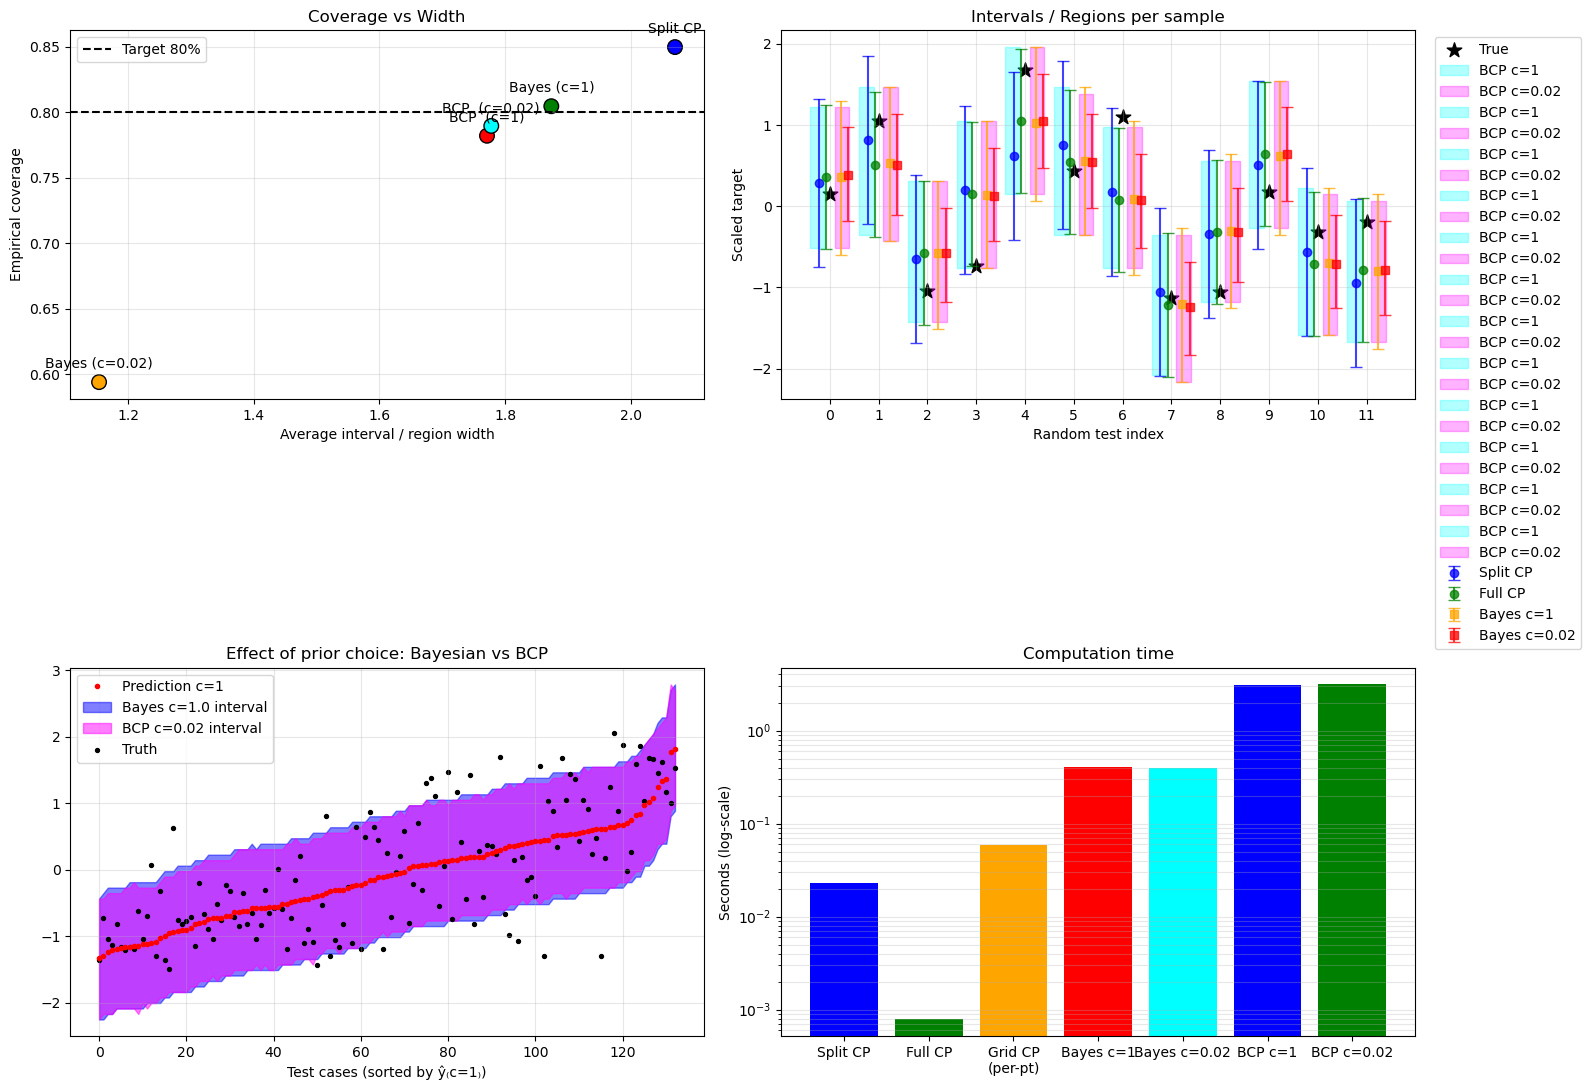

In [40]:
# ──────────────────────────────────  VISUALISATION  ──────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 11))

# ── 1 ▸ Coverage vs Width ────────────────────────────────────────────────────────────
plt.subplot(2, 2, 1)

methods = [
    'Split CP',
    'Bayes (c=1)', 'Bayes (c=0.02)',
    'BCP  (c=1)', 'BCP  (c=0.02)'
]
colors = ['blue', 'green',
          'orange', 'red', 'cyan']

coverage_values = [
    split_coverage, 
    coverage_c1, coverage_c002,
    cb_coverage_c1, cb_coverage_c002
]
width_values = [
    split_width, 
    width_c1, width_c002,
    cb_width_c1, cb_width_c002
]

plt.scatter(width_values, coverage_values, c=colors, s=110, edgecolor='k')
for i, txt in enumerate(methods):
    plt.annotate(txt, (width_values[i], coverage_values[i]),
                 xytext=(0, 10), textcoords='offset points', ha='center')

plt.axhline(1 - alpha, ls='--', color='black', label=f'Target {100*(1-alpha):.0f}%')
plt.xlabel('Average interval / region width')
plt.ylabel('Empirical coverage')
plt.title('Coverage vs Width')
plt.grid(alpha=.3)
plt.legend()

# ── 2 ▸ Intervals / regions on random test cases ─────────────────────────────────────
sample_size = min(12, len(y_test))
idx = np.sort(np.random.choice(len(y_test), sample_size, replace=False))
x_pos = np.arange(sample_size)
bar = 0.15

plt.subplot(2, 2, 2)
plt.scatter(x_pos, y_test[idx], marker='*', s=120, c='black', label='True')

# split / full / grid CP
plt.errorbar(x_pos - 3*bar/2, split_pred[idx],
             yerr=[split_pred[idx] - split_lower[idx],
                   split_upper[idx] - split_pred[idx]],
             fmt='o', capsize=4, color='blue',  alpha=.75, label='Split CP')
plt.errorbar(x_pos -  bar/2, full_pred[idx],
             yerr=[full_pred[idx] - full_lower[idx],
                   full_upper[idx] - full_pred[idx]],
             fmt='o', capsize=4, color='green', alpha=.75, label='Full CP')

# Bayesian credible intervals
plt.errorbar(x_pos + 3*bar/2, pred_c1[idx],
             yerr=[pred_c1[idx] - intervals_c1[idx, 0],
                   intervals_c1[idx, 1] - pred_c1[idx]],
             fmt='s', capsize=4, color='orange', alpha=.75, label='Bayes c=1')
plt.errorbar(x_pos + 5*bar/2, pred_c002[idx],
             yerr=[pred_c002[idx] - intervals_c002[idx, 0],
                   intervals_c002[idx, 1] - pred_c002[idx]],
             fmt='s', capsize=4, color='red',    alpha=.75, label='Bayes c=0.02')

# BCP regions (filled rectangles)
for i, j in enumerate(idx):
    plt.fill_between([i-0.4, i-0.1], cb_intervals_c1[j, 0], cb_intervals_c1[j, 1],
                     color='cyan', alpha=.3, label='BCP c=1')
    plt.fill_between([i+0.1, i+0.4], cb_intervals_c002[j, 0], cb_intervals_c002[j, 1],
                     color='magenta', alpha=.3, label='BCP c=0.02')

plt.xticks(x_pos)
plt.xlabel('Random test index')
plt.ylabel('Scaled target')
plt.title('Intervals / Regions per sample')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(alpha=.3)

# ── 3 ▸ Prior misspecification demonstration ────────────────────────────────────────
plt.subplot(2, 2, 3)

order = np.argsort(pred_c1)
x_all = np.arange(len(y_test))
plt.plot(x_all, pred_c1[order], 'or', markersize=3, label='Prediction c=1')

# plt.fill_between(x_all,
#                  intervals_c1[order, 0], intervals_c1[order, 1],
#                  color='orange', alpha=.25, label='Bayes c=1 interval')
# plt.fill_between(x_all,
#                  cb_intervals_c1[order, 0], cb_intervals_c1[order, 1],
#                  color='cyan', alpha=.5, label='BCP c=1 region')

plt.fill_between(x_all,
                 intervals_c1[order, 0], intervals_c1[order, 1],
                 color='blue', alpha=.5, label='Bayes c=1.0 interval')
plt.fill_between(x_all,
                 cb_intervals_c002[order, 0], cb_intervals_c002[order, 1],
                 color='magenta', alpha=.5, label='BCP c=0.02 interval')

plt.scatter(x_all, y_test[order], s=8, c='k', label='Truth')
plt.title('Effect of prior choice: Bayesian vs BCP')
plt.xlabel('Test cases (sorted by ŷ₍c=1₎)')
plt.grid(alpha=.3)
plt.legend()

# ── 4 ▸ Wall-clock time (log scale) ─────────────────────────────────────────────────
plt.subplot(2, 2, 4)

labels = ['Split CP', 'Full CP', 'Grid CP\n(per-pt)',
          'Bayes c=1', 'Bayes c=0.02',
          'BCP c=1',  'BCP c=0.02']
times = [split_time, full_time, grid_time / n_grid_points,
         Bayes_c1_time, Bayes_c002_time,
         BCP_c1_time,  BCP_c002_time]

plt.bar(labels, times, color=colors, log=True)
plt.ylabel('Seconds (log-scale)')
plt.title('Computation time')
plt.grid(alpha=.3, which='both', axis='y')

plt.tight_layout()
plt.show()


# Importance Weights

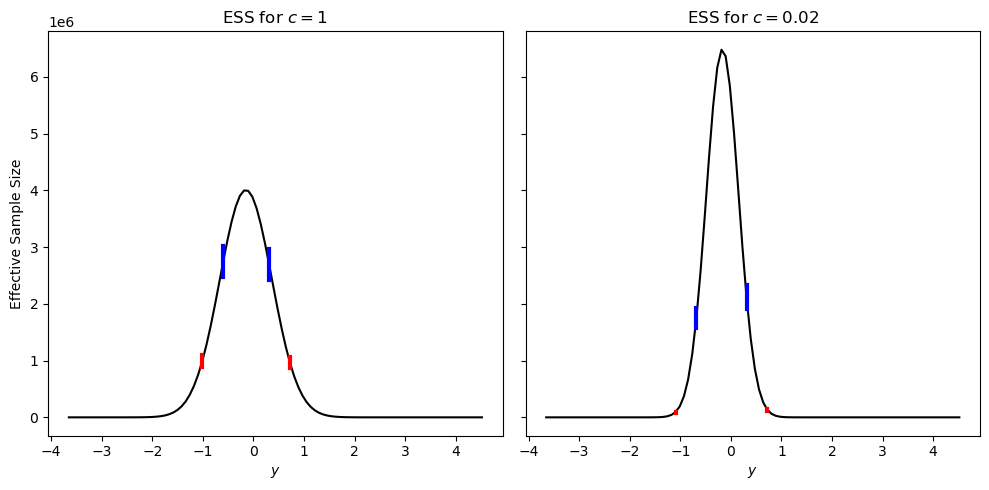

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

test_idx = 0
X_new = X_test[test_idx:test_idx+1]
y_true = y_test[test_idx]

alpha      = 0.2      # 80 % regions
n_test     = X_test.shape[0]
n_grid     = 100
y_min, y_max = y_train.min() - 2, y_train.max() + 2
y_grid     = jnp.linspace(y_min, y_max, n_grid)

# Compute log weights for the grid points for both priors
log_weights_c1 = compute_log_weights(y_grid, X_new, theta_samples_c1, intercept_samples_c1, tau_samples_c1)
log_weights_c002 = compute_log_weights(y_grid, X_new, theta_samples_c002, intercept_samples_c002, tau_samples_c002)
ESS_c1, _ = diagnose_IS_weights(log_probs_train_c1, log_weights_c1)
ESS_c002, _ = diagnose_IS_weights(log_probs_train_c002, log_weights_c002)

ess_c1 = ESS_c1.squeeze().mean(axis=-1)
ess_c002 = ESS_c002.squeeze().mean(axis=-1)

# CI levels
alphas = [0.2, 0.5]
color_map = {0.2: 'red', 0.5: 'blue'}

# Use conformal-Bayes method for interval
def compute_interval(y_grid, log_weights, logp_train, alpha):
    mask = compute_cb_region_IS(alpha, logp_train, log_weights)
    idx = jnp.where(mask)[0]
    if idx.size == 0:
        return np.nan, np.nan
    return float(y_grid[idx[0]]), float(y_grid[idx[-1]])

# Updated to pass `logp_train` and use conformal-style logic
def add_ci_ticks(ax, y_grid, ess_curve, log_weights, logp_train, alpha, color, height_frac=0.1):
    lo, hi = compute_interval(y_grid, log_weights, logp_train, alpha)
    for x in [lo, hi]:
        y_val = np.interp(x, y_grid, ess_curve)
        h = height_frac * y_val
        ax.plot([x, x], [y_val - h, y_val + h], color=color, lw=3)

# Start plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Left plot: c = 1
axes[0].plot(y_grid, ess_c1, color='black')
axes[0].set_title('ESS for $c = 1$')
axes[0].set_xlabel('$y$')
axes[0].set_ylabel('Effective Sample Size')
for alpha in alphas:
    add_ci_ticks(axes[0], y_grid, ess_c1, log_weights_c1, log_probs_train_c1, alpha, color_map[alpha])

# Right plot: c = 0.02
axes[1].plot(y_grid, ess_c002, color='black')
axes[1].set_title('ESS for $c = 0.02$')
axes[1].set_xlabel('$y$')
for alpha in alphas:
    add_ci_ticks(axes[1], y_grid, ess_c002, log_weights_c002, log_probs_train_c002, alpha, color_map[alpha])

plt.tight_layout()
plt.show()
